# **Laptop Deep EDA+Price Prediction**

The following project is about the analysis of a dataset contaning data about laptops. 
The project can be divided in the following sections:<br>
- Dataset cleaning + Feature Engineering <br>
- Exploratory Data Analysis <br>
- Data preparation for ML (encoding, scaling) <br>
- ML modeling by Random Forest and XGBoost<br>
- Results Sumamry <br>

EDIT: By log-transforming the target variable 'price', I could achieve R2=0.93 with XGBoost! Without log transforming, R2 was closer to 0.88. <br>

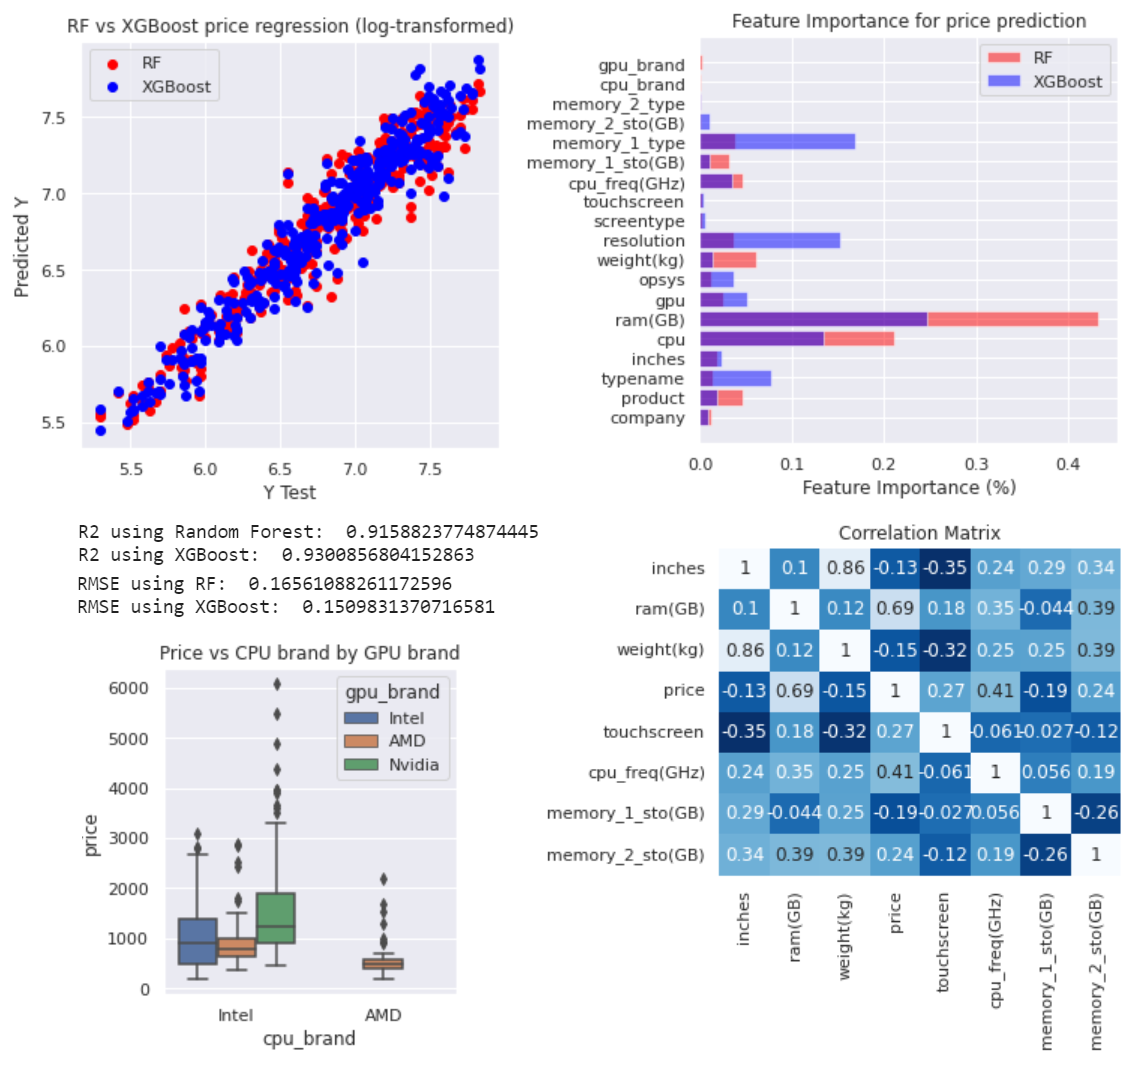

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/laptop-price/laptop_price.csv


In [6]:
df = pd.read_csv('/kaggle/input/laptop-price/laptop_price.csv', encoding="ISO-8859-1")

In [7]:
df.head()

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


There are just 2 numerical columns: 'inches' and 'price euros'.<br>

It could be good idea to change other columns into numerical, such as CPU, RAM, Memory and Weight

In [9]:
df.describe()

,laptop_ID,Inches,Price_euros
count,1303.000000,1303.000000,1303.000000
mean,660.155794,15.017191,1123.686992
std,381.172104,1.426304,699.009043
min,1.000000,10.100000,174.000000
25%,331.500000,14.000000,599.000000
50%,659.000000,15.600000,977.000000
75%,990.500000,15.600000,1487.880000
max,1320.000000,18.400000,6099.000000


Using the 'describe' method of the dataframe, we can get some first insights on the numerical columns.

-LaptopID: We can se that also laptopID is included as a numerical features, with a minimum value of 1 and max of 1320, different from the index (0-1303). This will be investigated later.<br>

-Inches: the nimimum inches is 10,1, while the max is 18.4 and the mean is around 15 inches<br>

-Price_euros:miimuim price is 174 euros, the max is 6099 and the mean is 1123, which is kinda high for a laptop<br>

# Data Cleaning 

Before exploring the data with EDA, we will perform some data cleaning.

First, we will change the columns into lower case.

In [10]:
df = df.rename(columns=str.lower)

In [11]:
df.columns

Index(['laptop_id', 'company', 'product', 'typename', 'inches',
       'screenresolution', 'cpu', 'ram', 'memory', 'gpu', 'opsys', 'weight',
       'price_euros'],
      dtype='object')

We will also rename 'price_euros' to 'price'

In [12]:
df = df.rename(columns={'price_euros':'price'})

## Check for duplicates

In [13]:
df[df.duplicated()]

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price


Good, there are no duplicates

Next, we will analyze each column and get some insights.

# Dataset Cleaning + Feature Engineering

## Laptop ID

In [14]:
df['laptop_id']

0          1
1          2
2          3
3          4
4          5
        ... 
1298    1316
1299    1317
1300    1318
1301    1319
1302    1320
Name: laptop_id, Length: 1303, dtype: int64

It is not clear why the laptop_id is different from the index by 18 values at the end 'index=1302 vs laptop_id=1320'

In [15]:
ind=0
for i in df['laptop_id']:
    if ind+1 != i:
        print(i)
        break
    ind+=1

66


After laptop_id=66, the index+1 (since with python lists start with 0) and laptop_id become different.

In [16]:
df[df['laptop_id']==66]

,laptop_id,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price
64,66,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.86kg,690.0


As we can see here, the difference between laptop_id and the index is 2, when it should be just 1.

Since we already have an index number for each laptop, we do not need the laptop_id column. It will be dropped.

In [17]:
df=df.drop('laptop_id', axis=1)

## Screen resolution

In [18]:
df['screenresolution']

0               IPS Panel Retina Display 2560x1600
1                                         1440x900
2                                Full HD 1920x1080
3               IPS Panel Retina Display 2880x1800
4               IPS Panel Retina Display 2560x1600
                           ...                    
1298     IPS Panel Full HD / Touchscreen 1920x1080
1299    IPS Panel Quad HD+ / Touchscreen 3200x1800
1300                                      1366x768
1301                                      1366x768
1302                                      1366x768
Name: screenresolution, Length: 1303, dtype: object

In the screen resolution column, there are included multiple useful informations.<br>
-Screen type<br>
-Resolution<br>
-Touchscreen?<br>
We will separate this 3 informations in 3 different columns.

### Feature Engineering on Screen resolution

In [19]:
df['resolution'] = df['screenresolution'].str.extract(r'(\d+x\d+)')

In [20]:
df['screentype'] = df['screenresolution'].replace(r'(\d+x\d+)','',regex=True)

In [21]:
df['screentype'] = df['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','',regex=True)

In [22]:
df['screentype']

0       IPS Panel Retina Display 
1                                
2                                
3       IPS Panel Retina Display 
4       IPS Panel Retina Display 
                  ...            
1298     IPS Panel   Touchscreen 
1299     IPS Panel   Touchscreen 
1300                             
1301                             
1302                             
Name: screentype, Length: 1303, dtype: object

Now we can extract the information about the presence of a touchscreen or not

In [23]:
df['touchscreen'] = df['screentype'].str.extract(r'(Touchscreen)')
df['screentype'] = df['screentype'].replace(r'(Touchscreen)','',regex=True)

In [24]:
df['touchscreen'].value_counts()

Touchscreen    192
Name: touchscreen, dtype: int64

In [25]:
df['touchscreen'] = df['touchscreen'].replace('Touchscreen',1)
df['touchscreen'] = df['touchscreen'].replace(np.nan,0)

In [26]:
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

In [27]:
df['screentype'].value_counts()

                             549
                             314
IPS Panel                    265
                              75
IPS Panel                     72
IPS Panel Retina Display      17
IPS Panel                     11
Name: screentype, dtype: int64

We can perform a further cleaning: there are actually only 2 screen types, IPS Panel and IPS Panel Retina Display (belonging to Apple laptops) even if by analyzing the different entries with value_counts we can see more than 2 different screen types.<br>
We will clean this.

In [28]:
df['screentype']=df['screentype'].replace(r' ','',regex=True)
df['screentype'].value_counts()

                         938
IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

Now we just need to subsitute the blank spaces with a 'NaN'

In [29]:
df['screentype'] = df['screentype'].replace(r'^\s*$', np.nan, regex=True)
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

Great! Now the dataframe looks like:

In [30]:
df.head()

,company,product,typename,inches,screenresolution,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0


We can so drop the original 'screenresolution' column!

In [31]:
df = df.drop('screenresolution', axis=1)

In [32]:
df.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0


The newly created columns are as follows:

In [33]:
df['resolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     43
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: resolution, dtype: int64

In [34]:
df['screentype'].value_counts()

IPSPanel                 348
IPSPanelRetinaDisplay     17
Name: screentype, dtype: int64

In [35]:
df['touchscreen'].value_counts()

0.0    1111
1.0     192
Name: touchscreen, dtype: int64

Everything looks okay.<br>
Now we will perform the same feature engineering process to CPU column

## CPU

In [36]:
df['cpu']

0                       Intel Core i5 2.3GHz
1                       Intel Core i5 1.8GHz
2                 Intel Core i5 7200U 2.5GHz
3                       Intel Core i7 2.7GHz
4                       Intel Core i5 3.1GHz
                        ...                 
1298              Intel Core i7 6500U 2.5GHz
1299              Intel Core i7 6500U 2.5GHz
1300    Intel Celeron Dual Core N3050 1.6GHz
1301              Intel Core i7 6500U 2.5GHz
1302    Intel Celeron Dual Core N3050 1.6GHz
Name: cpu, Length: 1303, dtype: object

We want to extract the CPU Frequency into a different column

In [37]:
df['cpu_freq'] = df['cpu'].str.extract(r'(\d+(?:\.\d+)?GHz)') 

With this regex we can extract both float and int frequencies for the CPU

In [38]:
df['cpu_freq'].value_counts()

2.5GHz     290
2.7GHz     165
2.8GHz     165
1.6GHz     133
2.3GHz      86
1.8GHz      78
2.6GHz      76
2GHz        67
1.1GHz      53
2.4GHz      52
2.9GHz      21
3GHz        19
2.0GHz      19
1.2GHz      15
1.44GHz     12
2.2GHz      11
1.5GHz      10
1.3GHz       6
3.6GHz       5
0.9GHz       4
3.1GHz       3
2.1GHz       3
2.50GHz      3
1.9GHz       2
1.60GHz      1
3.2GHz       1
1.0GHz       1
1.92GHz      1
2.70GHz      1
Name: cpu_freq, dtype: int64

Since all the frequencies are in GHz, we can now simply remove 'GHz' and add it to the column name, such that the column can become numerical

In [39]:
df['cpu_freq'] = df['cpu_freq'].str.replace('GHz', '')
df.rename(columns={'cpu_freq': 'cpu_freq(GHz)'}, inplace=True)

In [40]:
df['cpu_freq(GHz)'] = df['cpu_freq(GHz)'].astype(float)

Then, we delete the frequency from the CPU column.

In [41]:
df['cpu']= df['cpu'].str.replace(r'(\d+(?:\.\d+)?GHz)', '', regex=True)

In [42]:
df.head()

,company,product,typename,inches,cpu,ram,memory,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz)
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1


## RAM

We will remove GB from each row and add it in the column name instead.

In [43]:
df['ram'] = df['ram'].str.replace('GB', '')

In [44]:
df.rename(columns={'ram': 'ram(GB)'}, inplace=True)

In [45]:
df['ram(GB)'] = df['ram(GB)'].astype(int)

In [46]:
df.head()

,company,product,typename,inches,cpu,ram(GB),memory,gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz)
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1


## Memory

In [47]:
df['memory']

0                 128GB SSD
1       128GB Flash Storage
2                 256GB SSD
3                 512GB SSD
4                 256GB SSD
               ...         
1298              128GB SSD
1299              512GB SSD
1300     64GB Flash Storage
1301                1TB HDD
1302              500GB HDD
Name: memory, Length: 1303, dtype: object

We can extract lots of informations from this column. We can see that some laptops have 2 hard drives, there are 4 differnt types of disks: 'SSD', ''HDD', 'Hybrid' and 'Flash Storage'. We will create new columns to include all these information.

First, let's convert all the element into GB

In [48]:
df['memory'].value_counts()

256GB SSD                        412
1TB HDD                          223
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1.0TB Hybrid                       9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
180GB SSD                          5
128GB Flash Storage                4
512GB SSD +  2TB HDD               3
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [49]:
df['memory_1']=df['memory']

In [50]:
df['memory_1']=df['memory_1'].str.replace('1.0TB','1TB', regex=True)
df['memory_1']=df['memory_1'].str.replace('1TB','1000GB')
df['memory_1']=df['memory_1'].str.replace('2TB','2000GB')
df['memory_1']=df['memory_1'].str.replace('GB','')
df['memory_1'].value_counts()

256 SSD                         412
1000 HDD                        224
500 HDD                         132
512 SSD                         118
128 SSD +  1000 HDD              94
128 SSD                          76
256 SSD +  1000 HDD              73
32 Flash Storage                 38
2000 HDD                         16
64 Flash Storage                 15
512 SSD +  1000 HDD              14
1000 SSD                         14
256 SSD +  2000 HDD              10
1000 Hybrid                       9
256 Flash Storage                 8
16 Flash Storage                  7
32 SSD                            6
180 SSD                           5
128 Flash Storage                 4
512 SSD +  2000 HDD               3
16 SSD                            3
512 Flash Storage                 2
1000 SSD +  1000 HDD              2
256 SSD +  500 HDD                2
128 SSD +  2000 HDD               2
256 SSD +  256 SSD                2
512 SSD +  256 SSD                1
512 SSD +  512 SSD          

We transformed the drive capacity to GB

In [51]:
df['memory2']=df['memory_1'].str.replace(r' ','')
df['memory2'].value_counts()

256SSD                    412
1000HDD                   224
500HDD                    132
512SSD                    118
128SSD+1000HDD             94
128SSD                     76
256SSD+1000HDD             73
32FlashStorage             38
2000HDD                    16
64FlashStorage             15
512SSD+1000HDD             14
1000SSD                    14
256SSD+2000HDD             10
1000Hybrid                  9
256FlashStorage             8
16FlashStorage              7
32SSD                       6
180SSD                      5
128FlashStorage             4
512SSD+2000HDD              3
16SSD                       3
512FlashStorage             2
1000SSD+1000HDD             2
256SSD+500HDD               2
128SSD+2000HDD              2
256SSD+256SSD               2
512SSD+256SSD               1
512SSD+512SSD               1
64FlashStorage+1000HDD      1
1000HDD+1000HDD             1
32HDD                       1
64SSD                       1
128HDD                      1
240SSD    

In [52]:
import regex as re
memory_1=[]
memory_2=[]
for i in df['memory2']:
    if len(re.findall(r'\+',i))==1: # DOUBLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append(one[1])
    else: # SINGLE DRIVE
        one=re.findall(r'(\w+)',i)
        memory_1.append(one[0])
        memory_2.append('NaN')


Now we have separated the drives into two lists. We will now create two more lists that will contain the memory types.

In [53]:
memory_1_gb=[]
memory_1_type=[]
for i in memory_1:
    memory_1_type.append(re.findall(r'(\D\w+)',i)[0])
    memory_1_gb.append(re.findall(r'(\d+)',i)[0])

We created succesfully two lists for memory_1 in order to include the capacity and type for each memory 1

### Memory 2

In [54]:
memory_2_gb=[]
memory_2_type=[]
for i in memory_2:
    if i != 'NaN':
        memory_2_type.append(re.findall(r'(\D\w+)',i)[0])
        memory_2_gb.append(re.findall(r'(\d+)',i)[0])
    else:
        memory_2_type.append('NaN')
        memory_2_gb.append(0)

We created the same two lists that will contain type and capacity also for the second drive

In [55]:
df['memory_1_sto(GB)'] = memory_1_gb
df['memory_1_type'] = memory_1_type
df['memory_2_sto(GB)'] = memory_2_gb
df['memory_2_type'] = memory_2_type

Then we convert the capacity related columns to floats

In [56]:
df['memory_1_sto(GB)'] = df['memory_1_sto(GB)'].astype(float)
df['memory_2_sto(GB)'] = df['memory_2_sto(GB)'].astype(float)

In [57]:
df.head()

,company,product,typename,inches,cpu,ram(GB),memory,gpu,opsys,weight,...,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1,memory2,memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128 SSD,128SSD,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,...,1440x900,NaN,0.0,1.8,128 Flash Storage,128FlashStorage,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,...,1920x1080,NaN,0.0,2.5,256 SSD,256SSD,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,...,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512 SSD,512SSD,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,...,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256 SSD,256SSD,256.0,SSD,0.0,NaN


In [58]:
df=df.drop(['memory_1','memory2','memory'], axis=1)

In [59]:
df = df.replace({'NaN': np.nan})

In [60]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight,price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34kg,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86kg,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83kg,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


## Weight

In [61]:
df['weight'].value_counts()

2.2kg     121
2.1kg      58
2.4kg      44
2.3kg      41
2.5kg      38
         ... 
3.25kg      1
4.7kg       1
1.55kg      1
1.18kg      1
4.0kg       1
Name: weight, Length: 179, dtype: int64

Do all rows have a weight specified in kg?

In [62]:
df['weight'].str.contains('kg').sum()

1303

Yes, every rows returned a True value (1), so we can say that every row has the weight specified in kg. Now we will remvoe 'kg' from the rows.

In [63]:
df['weight'] = df['weight'].str.replace('kg','').astype(float)

In [64]:
df.rename(columns={'weight': 'weight(kg)'}, inplace=True)

In [65]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN


## CPU and GPU manifacturing companies

In [66]:
df['cpu_brand'] = df['cpu'].str.extract(r'^(\w+)')
df['cpu_brand'].value_counts()

Intel      1240
AMD          62
Samsung       1
Name: cpu_brand, dtype: int64

Most of the laptops have an intel cpu, few AMD and even one samsung one. Which is the samsung one?

In [67]:
df[df['cpu_brand']=='Samsung']

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand
1191,Samsung,Chromebook Plus,2 in 1 Convertible,12.3,Samsung Cortex A72&A53,4,ARM Mali T860 MP4,Chrome OS,1.15,659.0,2400x1600,IPSPanel,1.0,2.0,32.0,FlashStorage,0.0,NaN,Samsung


This sample will be dropped to simplify the further analysis and comparison between intel and amd based laptops.

In [68]:
df=df.drop(1191)

In [69]:
df['gpu_brand'] = df['gpu'].str.extract(r'^(\w+)')
df['gpu_brand'].value_counts()

Intel     722
Nvidia    400
AMD       180
Name: gpu_brand, dtype: int64

There is one laptop with an ARM gpu, which is it?

In [70]:
df[df['gpu_brand']=='ARM']

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand


It's the same laptop with the samsung CPU.

In [71]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1302 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1302 non-null   object 
 1   product           1302 non-null   object 
 2   typename          1302 non-null   object 
 3   inches            1302 non-null   float64
 4   cpu               1302 non-null   object 
 5   ram(GB)           1302 non-null   int64  
 6   gpu               1302 non-null   object 
 7   opsys             1302 non-null   object 
 8   weight(kg)        1302 non-null   float64
 9   price             1302 non-null   float64
 10  resolution        1302 non-null   object 
 11  screentype        364 non-null    object 
 12  touchscreen       1302 non-null   float64
 13  cpu_freq(GHz)     1302 non-null   float64
 14  memory_1_sto(GB)  1302 non-null   float64
 15  memory_1_type     1302 non-null   object 
 16  memory_2_sto(GB)  1302 non-null   float64


Now the dataset looks clean and ready to be explored

In [73]:
df.to_csv('laptop-clean.csv', index=False)

# Exploratory Data Analysis EDA

In [74]:
df1=pd.read_csv('laptop-clean.csv')
df1.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


Moreover, we will create a new dataframe df2 which will contain a further cleaned version of df (without outliers etc..)

In [75]:
df_clean=df.copy()

### Which brand is the most frequent in the dataframe?

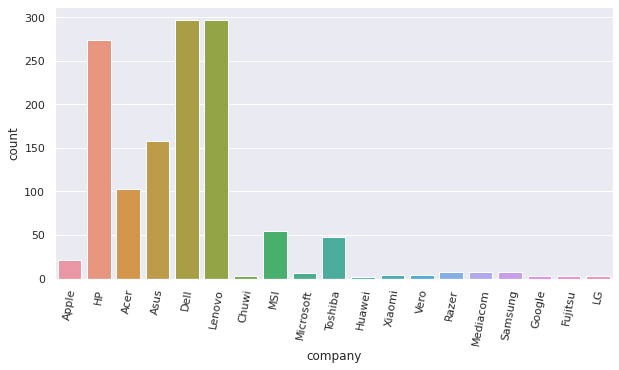

In [76]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='company', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);

In [77]:
df['company'].value_counts(ascending=True)

Huawei         2
LG             3
Google         3
Chuwi          3
Fujitsu        3
Vero           4
Xiaomi         4
Microsoft      6
Mediacom       7
Razer          7
Samsung        8
Apple         21
Toshiba       48
MSI           54
Acer         103
Asus         158
HP           274
Lenovo       297
Dell         297
Name: company, dtype: int64

Most of laptops are from Dell, Lenovo and HP. There are only 2-3 laptops from some companies as well.

### What type of laptop is the most frequent?

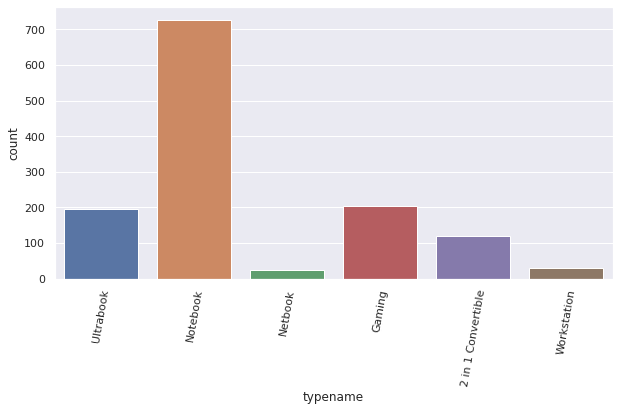

In [78]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='typename', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);

In [79]:
print('Most laptops are notebooks, which make {}% of the total laptops'.format(np.round(len(df[df['typename']=='Notebook'])*100/len(df),2)))

Most laptops are notebooks, which make 55.84% of the total laptops


Which size is the most popular?

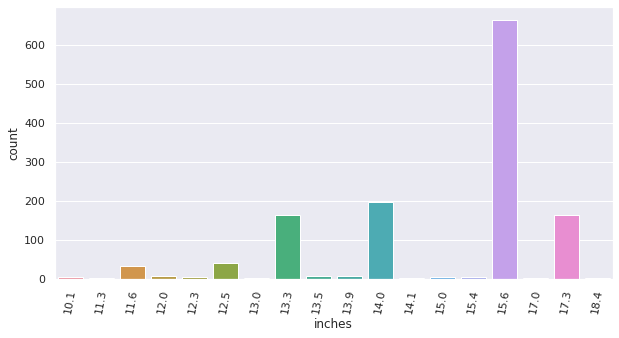

In [80]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.countplot(x='inches', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=80);

In [81]:
print('Most laptops have 15.6 inches, which make {}% of the total laptops'.format(np.round(len(df[df['inches']==15.6])*100/len(df),2)))

Most laptops have 15.6 inches, which make 51.08% of the total laptops


In [82]:
df['inches'].value_counts(ascending=True)

11.3      1
17.0      1
18.4      1
14.1      1
13.0      2
15.0      4
15.4      4
12.3      4
10.1      4
13.9      6
13.5      6
12.0      6
11.6     33
12.5     39
17.3    164
13.3    164
14.0    197
15.6    665
Name: inches, dtype: int64

<AxesSubplot:xlabel='inches'>

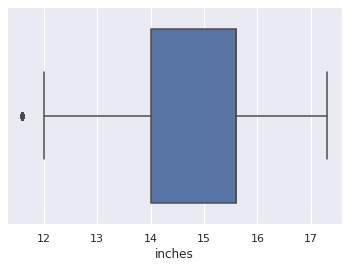

In [83]:
sns.boxplot(x='inches', data=df[(df['inches'] <=17.3) & (df['inches'] >= 11.6)])

In [84]:
df[(df['inches'] >17.3) | (df['inches'] < 11.6)].shape

(6, 20)

There are 6 values which could be considered as outliers, in the boxplot also the size '11.6' is labeled as an outlier, but this would mean to drop 33 more values. For now we just drop these 6 values.

In [85]:
df_clean = df_clean.loc[(df['inches'] <=17.3) & (df['inches'] >= 11.6)]

In [86]:
print('We removed {} outliers!'.format(len(df)-len(df_clean)))

We removed 6 outliers!


<AxesSubplot:xlabel='inches'>

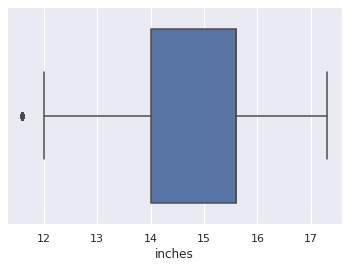

In [87]:
sns.boxplot(x='inches', data=df_clean)

### How is the weight distributed over all the laptops?

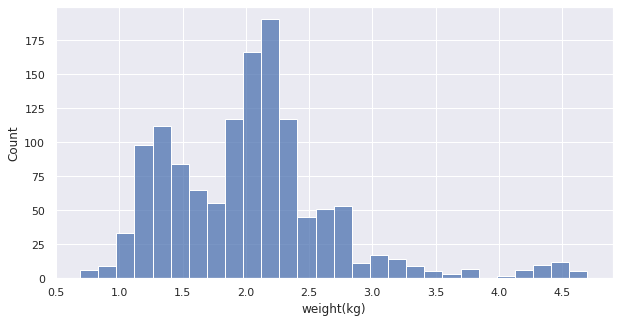

In [88]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.histplot(x='weight(kg)', data=df)

There are some laptops with a weight higher than 3.5 which could be considered as outliers, this will be further investigated

In [89]:
print('Average weight is: {} kg'.format(np.round(df['weight(kg)'].mean(),2)))
print('Median weight size is: {} kg'.format(df['weight(kg)'].median()))
print('Mode weight size is: {} kg'.format(df['weight(kg)'].mode()[0]))

Average weight is: 2.04 kg
Median weight size is: 2.04 kg
Mode weight size is: 2.2 kg


In [90]:
df.loc[df['weight(kg)'] > 3.5]['weight(kg)'].value_counts(ascending=True)

4.40     1
3.74     1
3.80     1
4.50     1
4.33     1
3.52     1
3.60     1
4.70     1
4.00     2
3.58     2
4.20     3
4.14     3
4.30     4
4.36     4
4.60     4
3.78     5
4.42    11
Name: weight(kg), dtype: int64

<AxesSubplot:xlabel='weight(kg)'>

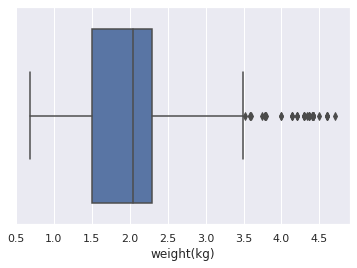

In [91]:
sns.boxplot(x='weight(kg)', data=df)

In [92]:
df_clean = df_clean.loc[df['weight(kg)'] < 3.5]

In [93]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 51 outliers!


<AxesSubplot:xlabel='weight(kg)'>

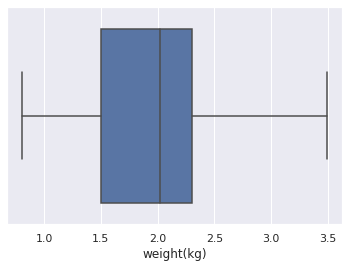

In [94]:
sns.boxplot(x='weight(kg)', data=df_clean)

### How is the price distributed among the laptops?

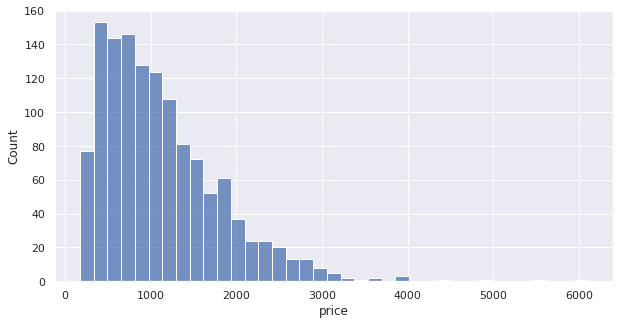

In [95]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.histplot(x='price', data=df)

In [96]:
print('Average price is: {} euros '.format(np.round(df['price'].mean(),2)))
print('Median price size is: {} euros '.format(df['price'].median()))
print('Mode price size is: {} euros '.format(df['price'].mode()[0]))

Average price is: 1124.04 euros 
Median price size is: 978.0 euros 
Mode price size is: 1099.0 euros 


It looks like there are some laptops with a price over 3000 euros!

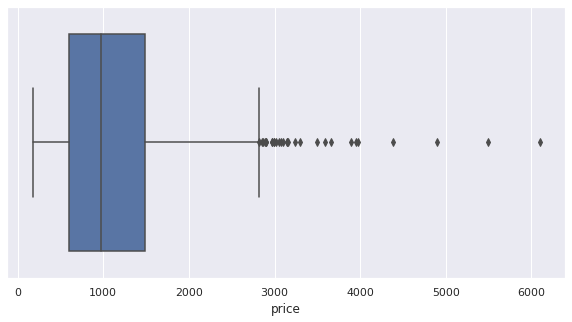

In [97]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.boxplot(x='price', data=df)

<AxesSubplot:xlabel='typename', ylabel='price'>

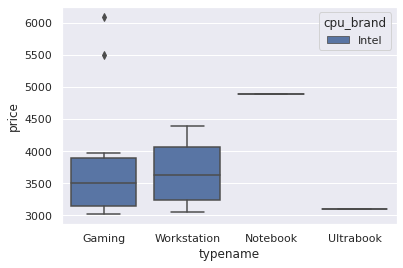

In [98]:
sns.boxplot(x='typename', y='price', data=df[df['price']>3000], hue='cpu_brand')

It looks like most of them are Gaming PCs or Workstations with intel CPU. There is also one Notebook with a price close to 5000 euros and 2 outlier values for Gaming Pc, with a price close to 5500 euros and 6000 euros

In [99]:
df[df['price']>4500]

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
196,Razer,Blade Pro,Gaming,17.3,Intel Core i7 7820HK,32,Nvidia GeForce GTX 1080,Windows 10,3.49,6099.0,3840x2160,NaN,1.0,2.9,1000.0,SSD,0.0,NaN,Intel,Nvidia
610,Lenovo,Thinkpad P51,Notebook,15.6,Intel Xeon E3-1535M v6,32,Nvidia Quadro M2200M,Windows 10,2.50,4899.0,3840x2160,IPSPanel,0.0,3.1,1000.0,SSD,0.0,NaN,Intel,Nvidia
830,Razer,Blade Pro,Gaming,17.3,Intel Core i7 7820HK,32,Nvidia GeForce GTX 1080,Windows 10,3.49,5499.0,3840x2160,NaN,1.0,2.9,512.0,SSD,0.0,NaN,Intel,Nvidia


The expensive notebook is the Lenovo Thinkpad P51, with an Intel XEON CPU and Nvidia Quadro GPU!!

### What about the price distribution of the cleaned dataframe df_2?

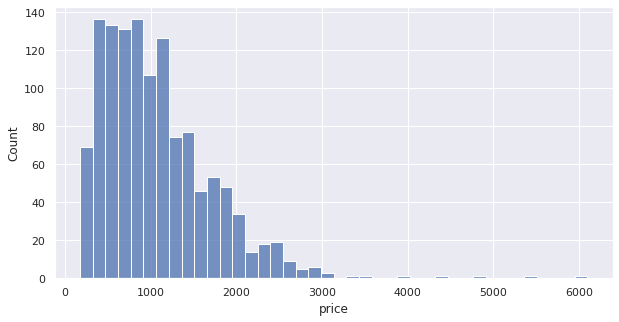

In [100]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.histplot(x='price', data=df_clean)

Good news! It looks like some outliers in tersm of price that were present in the original datafrma 'df' are not present in the cleaned datafrmae df_2.

<AxesSubplot:xlabel='price'>

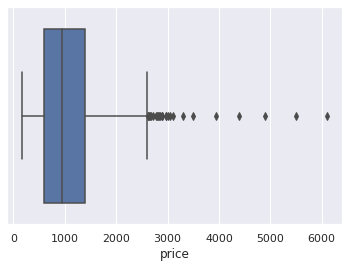

In [101]:
sns.boxplot(x='price', data=df_clean)

We will define a function that can identify the higher and lower fence!

In [102]:
def iqr_fence(x):
    Q1 = x.quantile(0.25)
    Q3 = x.quantile(0.75)
    IQR = Q3 - Q1
    Lower_Fence = Q1 - (1.5 * IQR)
    Upper_Fence = Q3 + (1.5 * IQR)
    u = max(x[x<Upper_Fence])
    l = min(x[x>Lower_Fence])
    print('Lower Fence:', l)
    print('Higher Fence:', u)
    return [u,l]

In [103]:
iqr_fence(df_clean['price'])

Lower Fence: 174.0
Higher Fence: 2599.0


[2599.0, 174.0]

In [104]:
df_clean[df_clean['price'] >2599]['price'].value_counts(ascending=True)

2858.00    1
3949.40    1
2620.00    1
3100.00    1
2649.00    1
2774.63    1
5499.00    1
4389.00    1
3299.00    1
2813.75    1
2680.00    1
4899.00    1
2799.00    1
2625.00    1
2712.00    1
2639.00    1
2884.86    1
3055.00    1
6099.00    1
2824.00    1
2999.00    1
3499.00    1
2968.00    2
2899.00    2
Name: price, dtype: int64

Indeed there are very few laptops with these prices. We will consider them as outliers and remove them.

In [105]:
df_clean = df_clean.loc[df['price'] < 2599]

In [106]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 78 outliers!


<AxesSubplot:xlabel='price'>

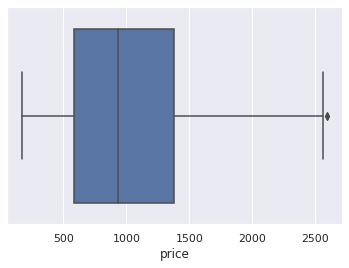

In [107]:
sns.boxplot(x='price', data=df_clean)

### How is the RAM distributed over the laptops?

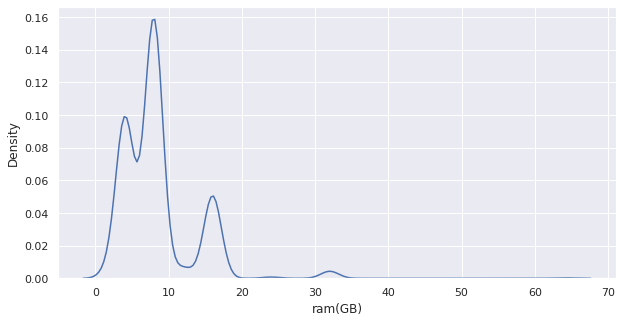

In [108]:
fig, ax  = plt.subplots(figsize=(10,5))
ax=sns.kdeplot(x='ram(GB)', data=df)

In [109]:
print('Most laptops have 8 GB RAM, which make {}% of the total laptops'.format(np.round(len(df[df['ram(GB)']==8])*100/len(df),2)))

Most laptops have 8 GB RAM, which make 47.54% of the total laptops


In [110]:
print('Average RAM is: {} GB '.format(np.round(df['ram(GB)'].mean(),2)))
print('Median RAM size is: {} GB '.format(df['ram(GB)'].median()))
print('Mode RAM size is: {} GB '.format(df['ram(GB)'].mode()[0]))

Average RAM is: 8.39 GB 
Median RAM size is: 8.0 GB 
Mode RAM size is: 8 GB 


<AxesSubplot:xlabel='ram(GB)'>

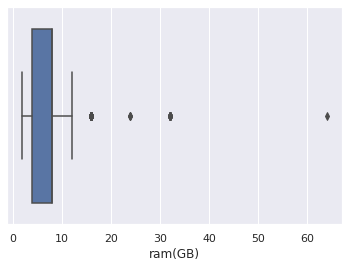

In [111]:
sns.boxplot(x='ram(GB)', data=df)

In [112]:
iqr_fence(df_clean['ram(GB)'])

Lower Fence: 2
Higher Fence: 12


[12, 2]

In [113]:
df_clean['ram(GB)'].value_counts(ascending=True)

24      1
2      22
12     23
6      41
16    156
4     370
8     611
Name: ram(GB), dtype: int64

It looks like there is a laptop with 24 GBs of ram in the cleaned dataframe ! We will remove it !!

In [114]:
df_clean = df_clean.loc[df_clean['ram(GB)']<=16]

In [115]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 79 outliers!


<AxesSubplot:xlabel='ram(GB)'>

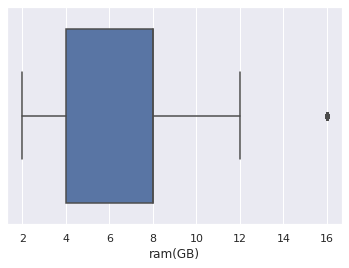

In [116]:
sns.boxplot(x='ram(GB)', data=df_clean)

So far we have done some further data cleaning by removing outliers! Let's check the cleaned dataframe df_2!

### How is the CPU frequency distributed?

<AxesSubplot:xlabel='cpu_freq(GHz)', ylabel='Count'>

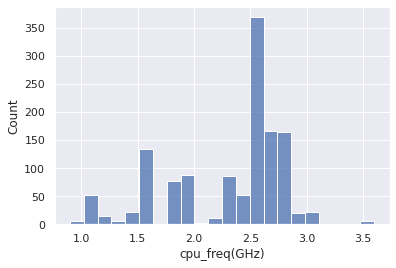

In [117]:
sns.histplot(x='cpu_freq(GHz)', data=df)

In [118]:
print('Average CPU frequency is: {} GHz '.format(np.round(df['cpu_freq(GHz)'].mean(),2)))
print('Median RAM size is: {} GHz '.format(df['cpu_freq(GHz)'].median()))
print('Mode RAM size is: {} GHz '.format(df['cpu_freq(GHz)'].mode()[0]))

Average CPU frequency is: 2.3 GHz 
Median RAM size is: 2.5 GHz 
Mode RAM size is: 2.5 GHz 


In [119]:
print('Most laptops have 2.5 GHz CPU, which make {}% of the total laptops'.format(np.round(len(df[df['cpu_freq(GHz)']==2.5])*100/len(df),2)))

Most laptops have 2.5 GHz CPU, which make 22.5% of the total laptops


<AxesSubplot:xlabel='cpu_freq(GHz)'>

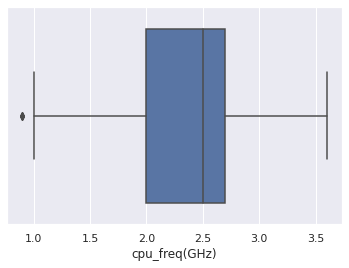

In [120]:
sns.boxplot(x='cpu_freq(GHz)', data=df)

It looks like there is one outlier value! It looks like to be a laptop with a CPU freq lowmer than 1GHz, lets check !

In [121]:
df.loc[df['cpu_freq(GHz)']<1]

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
697,Asus,Chromebook Flip,2 in 1 Convertible,12.5,Intel Core M M3-6Y30,4,Intel HD Graphics 515,Chrome OS,1.2,669.0,1920x1080,NaN,1.0,0.9,64.0,FlashStorage,0.0,NaN,Intel,Intel
1261,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.2,729.0,1920x1080,IPSPanel,0.0,0.9,512.0,SSD,0.0,NaN,Intel,Intel
1275,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.2,729.0,1920x1080,IPSPanel,0.0,0.9,512.0,SSD,0.0,NaN,Intel,Intel
1289,Asus,ZenBook UX305CA-UBM1,Ultrabook,13.3,Intel Core M 6Y30,8,Intel HD Graphics 515,Windows 10,1.2,729.0,1920x1080,IPSPanel,0.0,0.9,512.0,SSD,0.0,NaN,Intel,Intel


we can remove these 4 samples !

In [122]:
df_clean = df_clean.loc[df_clean['cpu_freq(GHz)']>=1]

In [123]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 83 outliers!


## Hard Drive capacity distribution

First, we will analyze the first hard drive storage capacity

Text(0.5, 0, 'First Hard Drive memory storage (GB)')

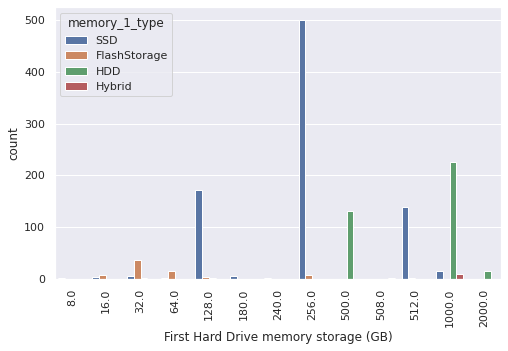

In [124]:
fig, ax  = plt.subplots(figsize=(8,5))
ax=sns.countplot(x='memory_1_sto(GB)', data=df, hue='memory_1_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('First Hard Drive memory storage (GB)')

<AxesSubplot:xlabel='memory_1_sto(GB)'>

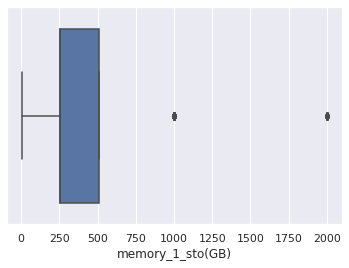

In [125]:
sns.boxplot(x='memory_1_sto(GB)', data=df)

In [126]:
df.loc[df['memory_1_sto(GB)']> 750]['memory_1_sto(GB)'].value_counts()

1000.0    250
2000.0     16
Name: memory_1_sto(GB), dtype: int64

We can remove the data related to PCs with 2TB storage!

In [127]:
df_clean = df_clean.loc[df_clean['memory_1_sto(GB)'] <= 1000]

In [128]:
print('In total we removed {} outliers!'.format(len(df)-len(df_clean)))

In total we removed 99 outliers!


Most PCs have 256 GB of storage, which is for the most part SSD. Moreover, for storage of 1 Tb or higher, most of them are HDD.

### Second hard Drive analysis

Text(0.5, 0, 'Second Hard Drive memory storage (GB)')

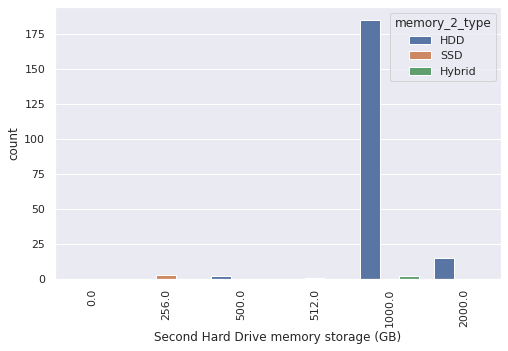

In [129]:
fig, ax  = plt.subplots(figsize=(8,5))
ax=sns.countplot(x='memory_2_sto(GB)', data=df, hue='memory_2_type')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);
ax.set_xlabel('Second Hard Drive memory storage (GB)')

Most of second hard drive storages are 1 TB HDD disks

The cleaned dataframe looks like:

In [130]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1302
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1203 non-null   object 
 1   product           1203 non-null   object 
 2   typename          1203 non-null   object 
 3   inches            1203 non-null   float64
 4   cpu               1203 non-null   object 
 5   ram(GB)           1203 non-null   int64  
 6   gpu               1203 non-null   object 
 7   opsys             1203 non-null   object 
 8   weight(kg)        1203 non-null   float64
 9   price             1203 non-null   float64
 10  resolution        1203 non-null   object 
 11  screentype        310 non-null    object 
 12  touchscreen       1203 non-null   float64
 13  cpu_freq(GHz)     1203 non-null   float64
 14  memory_1_sto(GB)  1203 non-null   float64
 15  memory_1_type     1203 non-null   object 
 16  memory_2_sto(GB)  1203 non-null   float64


Until now we analyzed each single feature at a time, in the following we will analyze these features together to find useful insghts about the data.

# Deeper EDA

Now we will analyze different features together

In [131]:
df_clean.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,2560x1600,IPSPanelRetinaDisplay,0.0,2.3,128.0,SSD,0.0,NaN,Intel,Intel
1,Apple,Macbook Air,Ultrabook,13.3,Intel Core i5,8,Intel HD Graphics 6000,macOS,1.34,898.94,1440x900,NaN,0.0,1.8,128.0,FlashStorage,0.0,NaN,Intel,Intel
2,HP,250 G6,Notebook,15.6,Intel Core i5 7200U,8,Intel HD Graphics 620,No OS,1.86,575.00,1920x1080,NaN,0.0,2.5,256.0,SSD,0.0,NaN,Intel,Intel
3,Apple,MacBook Pro,Ultrabook,15.4,Intel Core i7,16,AMD Radeon Pro 455,macOS,1.83,2537.45,2880x1800,IPSPanelRetinaDisplay,0.0,2.7,512.0,SSD,0.0,NaN,Intel,AMD
4,Apple,MacBook Pro,Ultrabook,13.3,Intel Core i5,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,2560x1600,IPSPanelRetinaDisplay,0.0,3.1,256.0,SSD,0.0,NaN,Intel,Intel


Text(0.5, 1.0, 'Price vs CPU_freq')

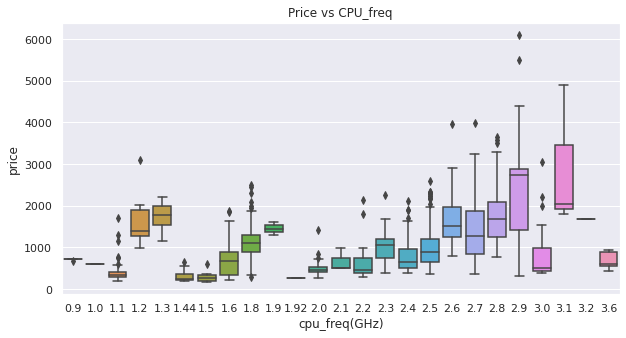

In [132]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='cpu_freq(GHz)', y='price', data=df)
ax.set_title('Price vs CPU_freq')

We can see that the price tends to increase for laptops with a higher CPU freq.<br>
In particular we can see an increasing trend in three different ranges (0.9-1.3GHz), (1.44-1.9GHz) and (1.92-3.1 GHz).<br>
Moreover, there are some laptops with a freq=3.6GHz with a price lower than 1000 euros, which are these PCs?

In [133]:
df[df['cpu_freq(GHz)']>3.5]

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
341,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD A12-Series 9720P,12,AMD Radeon 530,Windows 10,2.2,899.00,1920x1080,NaN,0.0,3.6,2000.0,HDD,0.0,NaN,AMD,AMD
591,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD A12-Series 9720P,12,AMD Radeon 530,Windows 10,2.2,949.00,1920x1080,NaN,0.0,3.6,512.0,SSD,0.0,NaN,AMD,AMD
702,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD A12-Series 9720P,8,AMD Radeon R7,Windows 10,2.2,429.00,1366x768,NaN,0.0,3.6,1000.0,HDD,0.0,NaN,AMD,AMD
982,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD A12-Series 9720P,6,AMD Radeon 530,Windows 10,2.2,549.00,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN,AMD,AMD
1240,Lenovo,IdeaPad 320-15ABR,Notebook,15.6,AMD A12-Series 9720P,6,AMD Radeon 530,Windows 10,2.2,597.57,1920x1080,NaN,0.0,3.6,256.0,SSD,0.0,NaN,AMD,AMD


These laptops are actually all 'Lenovo IdeaPad 320-15ABR' with different storage options. The processor with 3.6 GHz is the AMD A12-Series 9720P

Text(0.5, 1.0, 'Price vs CPU brand by GPU brand')

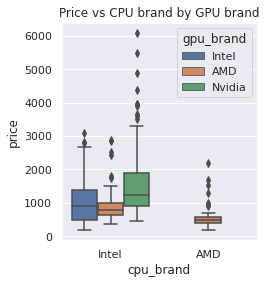

In [134]:
fig, ax = plt.subplots(figsize=(3.5,4))
sns.boxplot(x='cpu_brand', y='price', data=df, hue='gpu_brand')
ax.set_title('Price vs CPU brand by GPU brand')

From this plot we can see that on average, laptops with Intel CPU are more expensive. In particular, every PC with an AMD CPU also has and AMD GPU, while laptops with Intel CPU can have Intel, AMD or Nvidia GPU. Among these, those with Nvidia GPUs are more expensive.

Text(0.5, 1.0, 'CPU_freq vs CPU brand by GPU brand')

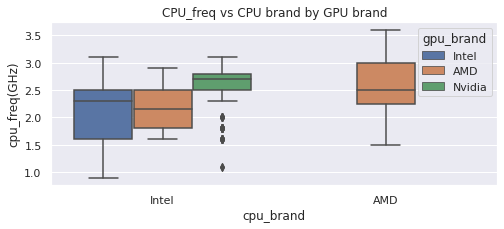

In [135]:
fig, ax = plt.subplots(figsize=(8,3))
sns.boxplot(x='cpu_brand', y='cpu_freq(GHz)', data=df, hue='gpu_brand')
ax.set_title('CPU_freq vs CPU brand by GPU brand')

We can see that on average AMD CPU have a higher CPU frequency compared to intel pc. Moreover, among intel based pcs, those with nvidia GPU have higher cpu frequency

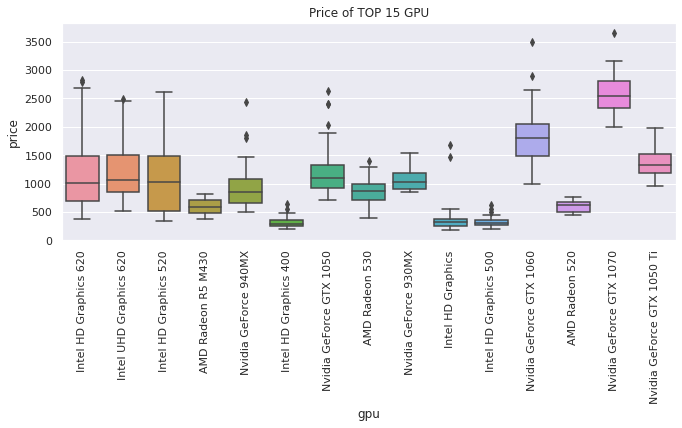

In [136]:
fig, ax = plt.subplots(figsize=(11,4))
sns.boxplot(x='gpu', y='price', data=df[df['gpu'].isin(df['gpu'].value_counts()[:15].index)])
ax.set_title('Price of TOP 15 GPU')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Among the laptops with the 15 most common GPU, those with Nvidia GPU are more expensive

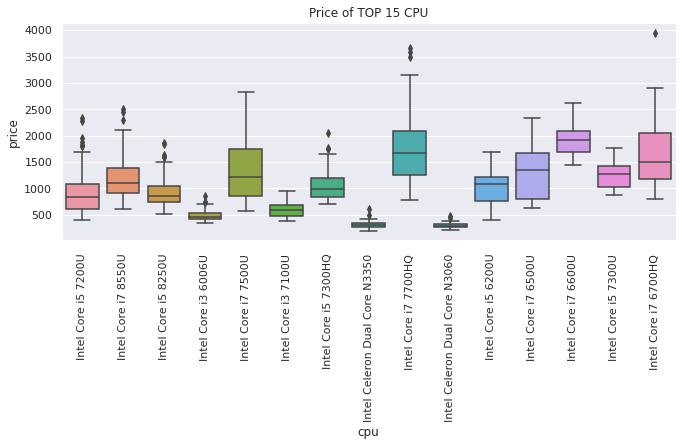

In [137]:
fig, ax = plt.subplots(figsize=(11,4))
sns.boxplot(x='cpu', y='price', data=df[df['cpu'].isin(df['cpu'].value_counts()[:15].index)])
ax.set_title('Price of TOP 15 CPU')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

Among the laptops with the 15 most common CPU, thosw tih the Intel core i7 7700HQ, 6700HQ and 7500U are more expensive.

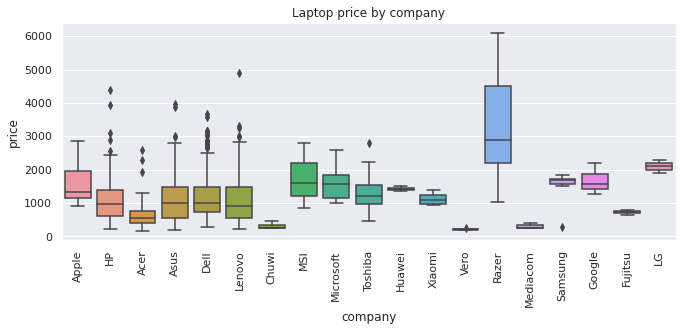

In [138]:
fig, ax = plt.subplots(figsize=(11,4))
sns.boxplot(x='company', y='price', data=df)
ax.set_title('Laptop price by company')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

We can see that Razer laptops have a wide range of prices (from 1000 to 6000), moreover we can see that MSI and Apple computers have similar min and max values: apple pcs are more common in the 1000-2000 euros range, while MSI PCs are more common in the 1200-2100 euros prie range.

## Correlation Matrix

The correlation matrix can give some useful informations about the linear correlation between the numerical features

Text(0.5, 1.0, 'Correlation Matrix')

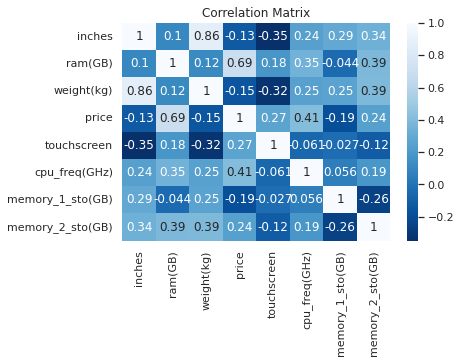

In [139]:
sns.heatmap(df_clean.corr(), cmap='Blues_r', annot=True)
plt.title('Correlation Matrix')

From the Correlation Matrix, about the laptop price we cay:<br>
- RAM has a large impact on the price (+0.69): more expensive laptops tends to have a higher price<br>
- also the CPU seems to have some positive correlation wrt the price (+0.41) <br>
Moreover, inches and weight have a high positive correlation (0.86) since laptops with bigger screen tend to be heavier

# Data preparation for ML modeling

<AxesSubplot:xlabel='price', ylabel='Count'>

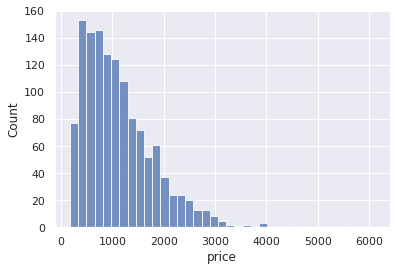

In [140]:
sns.histplot(x='price', data=df)

<AxesSubplot:xlabel='price', ylabel='Count'>

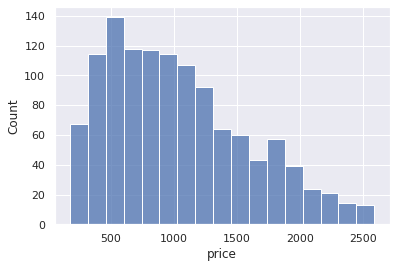

In [141]:
sns.histplot(x='price', data=df_clean)

For prediction, we will use the cleaned dataframe 'df_clean'

In [142]:
df1=df_clean.copy()

Moreover, since the target variable 'price' is right skewed, we will log transform it to improve the prediction performance of the algorithms.

In [143]:
df1['price']=np.log(df1['price'])

In [144]:
df1=df1.fillna('NaN')

## Categorical features encoding

The categorical columns ('company','product','typename','cpu','gpu','opsys','resolution','screentype','resolution','memory_1_type','memory_2_type','gpu_brand','cpu_brand') will be now encoded. <br>
An encoding by one hot encoding would be preferrable in this case since there is not a order/hierarchy among the different categories for each variable, but this would lead to a very high number of columns (around 900), which is close to the number or rows 1000.<br>
So, if we had more data a OHE encoding would be preferrable, but in case a Label Encoding will be performed to keep the number of features lower.

In [145]:
from sklearn.preprocessing import LabelEncoder
en = LabelEncoder()
catCols =  ['company','product','typename','cpu','gpu','opsys','resolution','screentype','resolution','memory_1_type','memory_2_type','gpu_brand','cpu_brand']
for cols in catCols:
    df1[cols] = en.fit_transform(df1[cols])

In [146]:
print('Dataframe encoded by OHE dimension : ', pd.get_dummies(df1, columns=catCols, drop_first=True).shape)

Dataframe encoded by OHE dimension :  (1203, 820)


In [147]:
df1.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),price,resolution,screentype,touchscreen,cpu_freq(GHz),memory_1_sto(GB),memory_1_type,memory_2_sto(GB),memory_2_type,cpu_brand,gpu_brand
0,1,278,4,13.3,46,8,54,7,1.37,7.200194,10,1,0.0,2.3,128.0,3,0.0,1,1,1
1,1,279,4,13.3,46,8,47,7,1.34,6.801216,1,2,0.0,1.8,128.0,0,0.0,1,1,1
2,7,43,3,15.6,52,8,49,3,1.86,6.354370,3,2,0.0,2.5,256.0,3,0.0,1,1,1
3,1,278,4,15.4,60,16,8,7,1.83,7.838915,12,1,0.0,2.7,512.0,3,0.0,1,1,0
4,1,278,4,13.3,46,8,55,7,1.37,7.497540,10,1,0.0,3.1,256.0,3,0.0,1,1,1


In [148]:
print('Dataframe encoded by OHE dimension : ', df1.shape)

Dataframe encoded by OHE dimension :  (1203, 20)


## Data preparation

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [150]:
X=df1.drop('price', axis = 1).values

In [151]:
y=df1['price'].values

In [152]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [153]:
scaler = StandardScaler()

In [154]:
scaler.fit(X_train)

StandardScaler()

In [155]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)            

## Random Forest

In [156]:
from sklearn.ensemble import RandomForestRegressor

In [157]:
rf = RandomForestRegressor(n_estimators=100, max_depth=100, max_features=15)

In [158]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=100, max_features=15)

In [159]:
y_pred_rf = rf.predict(X_test)

In [160]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("RMSE using RF: ", np.sqrt(mse_rf))

RMSE using RF:  0.16666841703031385


In [161]:
print("RF R2 score :", r2_score(y_test,y_pred_rf))

RF R2 score : 0.914804654755875


### Feature Importance

When using a random forest regressor, there is the possibility to plot the feature importance determined by the algorithm to perform the regression. It will be visualized to better understand what contributes the most to a laptop price.

First, we select the feature list (column names) from the X_train vector 

In [162]:
feature_name_list=df1.drop('price', axis = 1).columns

We use the column names as the feature names, so that in the following plot we will be able to see the actual feature names

In [163]:
rf.feature_names = feature_name_list

Text(0.5, 0, 'Feature Importance (%)')

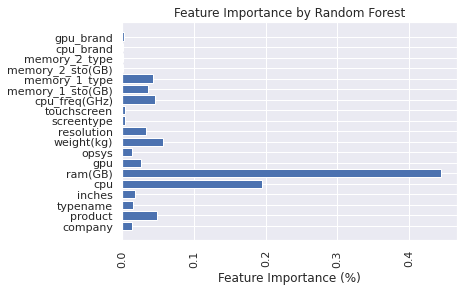

In [164]:
plt.barh(rf.feature_names,rf.feature_importances_)
plt.xticks(rotation=90);
plt.title('Feature Importance by Random Forest')
plt.xlabel('Feature Importance (%)')

## XGBoost

In [165]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=400, learning_rate=0.24, max_depth=3)
xgb.fit(X_train, y_train) 
y_pred_xgb = xgb.predict(X_test) 
mse_xgb = mean_squared_error(y_pred_xgb, y_test)
print("RMSE:" , np.sqrt(mse_xgb)) 
print("XGBoost R2 score :", r2_score(y_test,y_pred_xgb))

RMSE: 0.1509831370716581
XGBoost R2 score : 0.9300856804152863


In [166]:
xgb.feature_names = feature_name_list

# Results Summary

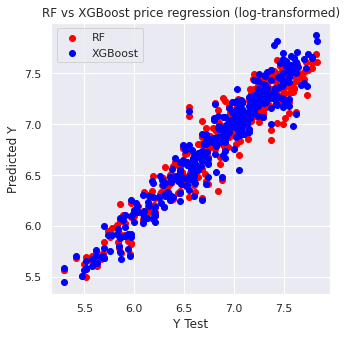

In [167]:
plt.figure(figsize = (5,5))
plt.scatter(y_test, y_pred_rf, label='RF', color='red')
plt.scatter(y_test, y_pred_xgb, label='XGBoost', color='blue')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('RF vs XGBoost price regression (log-transformed)')
plt.legend(loc='upper left');

In [168]:
print("RMSE using RF: ", np.sqrt(mse_rf))
print("RMSE using XGBoost: ", np.sqrt(mse_xgb))


RMSE using RF:  0.16666841703031385
RMSE using XGBoost:  0.1509831370716581


In [169]:
print("R2 using Random Forest: ",  r2_score(y_test, y_pred_rf))
print("R2 using XGBoost: ",  r2_score(y_test, y_pred_xgb))

R2 using Random Forest:  0.914804654755875
R2 using XGBoost:  0.9300856804152863


Text(0.5, 0, 'Feature Importance (%)')

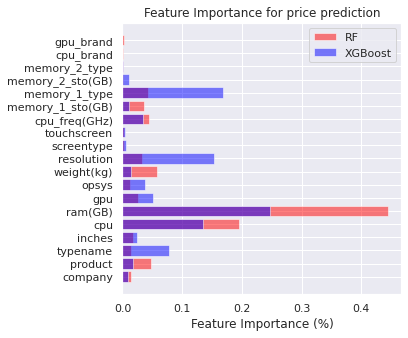

In [170]:
plt.figure(figsize=(5,5))
plt.barh(rf.feature_names,rf.feature_importances_, alpha=0.5, label='RF', color='red')
plt.barh(xgb.feature_names,xgb.feature_importances_, alpha=0.5, label='XGBoost', color='blue')
plt.legend(loc='upper right');
plt.title('Feature Importance for price prediction')
plt.xlabel('Feature Importance (%)')

We can see that RF chose RAM, CPU, weight and product(name) as the most important features.<br>
In the case of XGBoost, the most important features are RAM, memory_1_type, typename, cpu and resolution.<br>
It is also worth noticing XGBoost didnt give as much importance to RAM and CPU as RF did. It spreaded more the feature importance among others featureses